In [1]:
## RUNNING TIME
import time
import numpy as np
from scipy.integrate import quad
from scipy import stats
import numpy.random as npr
np.random.seed(500)
#Install import_ipynb so we can read dependenies as jupyter notebooks
!pip install ipynb
#Import jupyer notebook depdendencies 
from ipynb.fs.full.FFT_option_valuation_LEWIS import BSM_call_value_FFT, H93_call_value_FFT
from ipynb.fs.full.Lewis_Integration_option_valuation import BSM_call_value, H93_call_value


In [2]:
def BSM_call_valueAnalytical(S0, K, T, r, d, sigma):
    ''' Valuation of European call option in BSM Model.
    Analytical Formula.'''
    d1 = (np.log(S0 / K) + (r-d + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r-d - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    BS_C = (S0*np.exp(-d*T)* stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return BS_C

def MC_Euler_Scheme_Heston_optionpricing(S0, K, T, r, d,
                                         v0, kappa, theta, sigma, rho,
                                         M, I, option = 'put', vt_disct = 'full-truncation'):
    ''' The Monte-Carlo estimation for a European option using the 
    standard Euler-Maruyama scheme in Heston Model'''
    
    ran_num = npr.standard_normal((2, M + 1, I)) 
    dt = T / M
    corr_mat = np.zeros((2, 2))
    corr_mat[0, :] = [1.0, rho]
    corr_mat[1, :] = [rho, 1.0]
    cho_mat = np.linalg.cholesky(corr_mat)
    cho_mat
    v = np.zeros_like(ran_num[0])
    vh = np.zeros_like(v)
    v[0] = v0
    vh[0] = v0
    S = np.zeros_like(ran_num[0])    
    S[0] = S0
    for t in range(1, M + 1):
    
        ran = np.dot(cho_mat, ran_num[:, t, :])
        if vt_disct == 'full-truncation':
        #this scheme is called full-truncation
            vh[t] = (vh[t - 1] + kappa * (theta - np.maximum(vh[t - 1], 0)) * dt
                  + sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt) * ran[1])
            v[t] = np.maximum(0, vh[t])
        
        #this scheme is called Reflection
        elif vt_disct == 'reflection':
            vh[t] = (vh[t - 1] + kappa * (theta - np.abs(vh[t - 1])) * dt
                  + sigma * np.sqrt(np.abs(vh[t - 1])) * np.sqrt(dt) * ran[1])
            v[t] = np.abs(vh[t])
        
        S[t] = S[t - 1] * np.exp((r -d - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[0] * np.sqrt(dt))
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    elif option == 'put':
        hT = np.maximum(K - S[-1], 0)

    # calculation of MCS estimator for option price in Heston model
    option_price = np.exp(-(r-d) * T) * np.mean(hT)
    
    return option_price

In [3]:
# Test with sythetic data
# Comparision running time BSM model
# BSM Parameters
S0 = 100.0 ; K = 100.0 ; T = 1.; r = 0.05; sigma = 0.2; d = 0
# Compare running time in one iteration
start_time = time.time()
BSM_call_valueAnalytical(S0, K, T, r, d, sigma)
print("BSM_Analytical method", (time.time() - start_time), "seconds")
start_time = time.time()
BSM_call_value(S0, K, T, r, d, sigma)
print("BSM_FT method", (time.time() - start_time), "seconds")
start_time = time.time()
BSM_call_value_FFT(S0, K, T, r, d, sigma)
print("BSM_FFT method", (time.time() - start_time), "seconds")

# Comparision running time Heston model
# Heston Parameters
S0 = 100.0; K = 100.0; T = 1.0; r = 0.05; d = 0
kappa_v = 2; theta_v = 0.01; sigma_v = 0.1; rho = -0.5; v0 = 0.01

# MC simulation parameters:
M = 252
I = 500000
start_time = time.time()
MC_Euler_Scheme_Heston_optionpricing(S0, K, T, r, d,
                                     v0, kappa_v, theta_v, sigma_v, rho, 
                                     M, I, option = 'call', vt_disct = 'full-truncation')
print("Heston_MC", (time.time() - start_time), "seconds")
start_time = time.time()
H93_call_value(S0, K, T, r, d, kappa_v, theta_v, sigma_v, rho, v0)
print("Heston_Lewis", (time.time() - start_time), "seconds")
start_time = time.time()
H93_call_value_FFT(S0, K, T, r, d, kappa_v, theta_v, sigma_v, rho, v0)
print("Heston_FFT", (time.time() - start_time), "seconds")

BSM_Analytical method 0.002888917922973633 seconds
BSM_FT method 0.003695249557495117 seconds
BSM_FFT method 0.003710031509399414 seconds
Heston_MC 20.149394989013672 seconds
Heston_Lewis 0.008938312530517578 seconds
Heston_FFT 0.003258943557739258 seconds


In [4]:
import pandas as pd
options = pd.read_csv('bsm_option_data.csv')
options

,Maturity,Strike,Call,Date,T,r,impVol,Model FFT,Model LEWIS,err FFT,err LEWIS
0,2021-01-08,85.0,13.500,2020-12-28,0.030137,-0.000491,0.508845,13.500216,13.500000,0.000016,5.052748e-14
1,2021-01-08,87.5,11.000,2020-12-28,0.030137,-0.000491,0.425509,11.000219,11.000000,0.000020,6.201100e-14
2,2021-01-08,90.0,8.500,2020-12-28,0.030137,-0.000491,0.341989,8.500221,8.500000,0.000026,1.891883e-11
3,2021-01-08,92.5,6.000,2020-12-28,0.030137,-0.000491,0.257192,6.000224,6.000001,0.000037,1.008760e-07
4,2021-01-08,95.0,3.900,2020-12-28,0.030137,-0.000491,0.261689,3.900227,3.900000,0.000058,9.918865e-08
...,...,...,...,...,...,...,...,...,...,...,...
65,2021-12-17,80.0,21.750,2020-12-28,0.969863,0.000721,0.310039,21.750209,21.750000,0.000010,3.070851e-14
66,2021-12-17,90.0,15.500,2020-12-28,0.969863,0.000721,0.307944,15.500220,15.500000,0.000014,4.675830e-14
67,2021-12-17,100.0,10.750,2020-12-28,0.969863,0.000721,0.308097,10.750232,10.750000,0.000022,7.006282e-14
68,2021-12-17,110.0,6.800,2020-12-28,0.969863,0.000721,0.295504,6.800244,6.800000,0.000036,1.132427e-13


In [5]:
# Test with real data benchmark

import pandas as pd
options = pd.read_csv('bsm_option_data.csv')
#Define Stock price (Ericsson B, 28.12.2020)               
S0 = 98.36   
#Dividend yield
d = 0.0086

# Heston Calibrated parameter vector with Lewis:  [2.438 0.116 0.751 -0.416 0.095]
kappa_v = 2.438
theta_v = 0.116
sigma_v = 0.751
rho = -0.416
v0 = 0.095
start_time = time.time()
for row, option in options.iterrows():
    H93_call_value(S0, option['Strike'], option['T'],
                            option['r'], d, kappa_v, theta_v, sigma_v, rho, v0)
H93_call_value_time = (time.time() - start_time)
print("Total time Heston_FT", H93_call_value_time, "seconds")  


# Heston  Calibrated parameter vector with FFT:  [2.181 0.120 0.724 -0.461 0.098]
kappa_v = 2.181
theta_v = 0.120
sigma_v = 0.724
rho = -0.416
v0 = 0.098
start_time = time.time()
for row, option in options.iterrows():    
    H93_call_value_FFT(S0, option['Strike'], option['T'],
                            option['r'], d, kappa_v, theta_v, sigma_v, rho, v0)
    
H93_call_value_FFT_time = (time.time() - start_time)    
print("Total time Heston_FFT", H93_call_value_FFT_time, "seconds")
start_time = time.time()

for row, option in options.iterrows():    
    MC_Euler_Scheme_Heston_optionpricing(S0, option['Strike'], option['T'], option['r'], d,
                                     v0, kappa_v, theta_v, sigma_v, rho, 
                                     M, I, option = 'call', vt_disct = 'full-truncation')
MC_Euler_Scheme_Heston_optionpricing_time = (time.time() - start_time)    
print("Total time Heston_MC", MC_Euler_Scheme_Heston_optionpricing_time, "seconds")    

Total time Heston_FT 0.46665334701538086 seconds
Total time Heston_FFT 0.1391890048980713 seconds
Total time Heston_MC 1137.0668470859528 seconds


In [6]:
kappa_v = 2.181
theta_v = 0.120
sigma_v = 0.724
rho = -0.416
v0 = 0.098
max_iter = 5000
H93_call_value_FFT_time_list = []
for i in range(max_iter):
    start_time = time.time()
    for row, option in options.iterrows():    
        H93_call_value_FFT(S0, option['Strike'], option['T'],
                                option['r'], d, kappa_v, theta_v, sigma_v, rho, v0)

    H93_call_value_FFT_time = (time.time() - start_time)    
    H93_call_value_FFT_time_list.append(H93_call_value_FFT_time)

In [7]:
kappa_v = 2.438
theta_v = 0.116
sigma_v = 0.751
rho = -0.416
v0 = 0.095
H93_call_value_time_list = []
for i in range(max_iter):
    start_time = time.time()
    for row, option in options.iterrows():
        H93_call_value(S0, option['Strike'], option['T'],
                                option['r'], d, kappa_v, theta_v, sigma_v, rho, v0)
    H93_call_value_time = (time.time() - start_time)
    H93_call_value_time_list.append(H93_call_value_time)

In [8]:
BSM_call_valueAnalytical_list = []
for i in range(max_iter):
    start_time = time.time()
    for row, option in options.iterrows():
        BSM_call_valueAnalytical(S0, option['Strike'], option['T'], option['r'], d, option['impVol'])
#     print("BSM_Analytical method", (time.time() - start_time), "seconds")
    BSM_call_valueAnalytical_list.append(time.time() - start_time)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
def histo(H93_call_value_time_list, title) :
    plt.hist(H93_call_value_time_list, color = 'blue', edgecolor = 'black',
             bins = int(max_iter/5))

    # # seaborn histogram
    # sns.distplot(H93_call_value_FFT_time_list, hist=True, kde=False, 
    #              bins=int(max_iter/2), color = 'blue',
    #              hist_kws={'edgecolor':'black'})
    # Add labels
    plt.title(title)
    plt.xlabel('Running time(s)')
    plt.ylabel('Flights')

In [10]:
from statistics import mean 
def getMean(arr, name):    
    avg = mean(arr)
    print("The mean " + name, round(avg, 5))
    return avg

The mean BSM_call_valueAnalytical_list 0.03098


0.0309753155708313

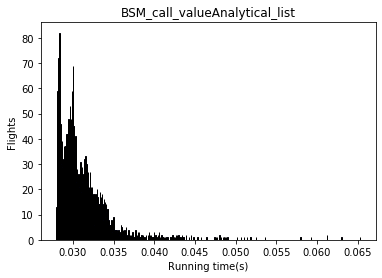

In [11]:
histo(BSM_call_valueAnalytical_list, "BSM_call_valueAnalytical_list")
getMean(BSM_call_valueAnalytical_list, "BSM_call_valueAnalytical_list")

The mean H93_call_value_FFT_time_list 0.13694


0.1369355254650116

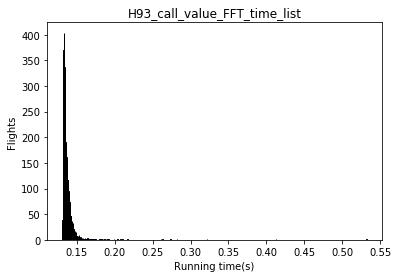

In [12]:
histo(H93_call_value_FFT_time_list, "H93_call_value_FFT_time_list")
getMean(H93_call_value_FFT_time_list, "H93_call_value_FFT_time_list")

The mean H93_call_value_1_list 0.4515


0.4514999922275543

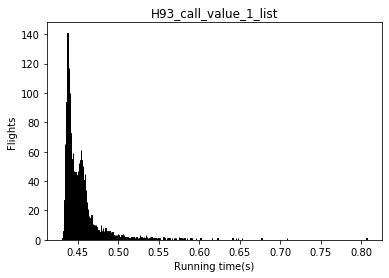

In [13]:
histo(H93_call_value_time_list, "H93_call_value_1_list")
getMean(H93_call_value_time_list, "H93_call_value_1_list")

In [14]:
# BSM Parameters
S0 = 100.0 ; K = 100.0 ; T = 1.; r = 0.05; sigma = 0.2; d = 0
# Compare running time in one iteration
max_iter = 5000
BSM_call_valueAnalytical_1_list = []
for i in range(max_iter):
    start_time = time.time()
    BSM_call_valueAnalytical(S0, K, T, r, d, sigma)
    BSM_call_valueAnalytical_1_list.append(time.time() - start_time)

In [15]:
# Comparision running time Heston model
# Heston Parameters
S0 = 100.0; K = 100.0; T = 1.0; r = 0.05; d = 0
kappa_v = 2; theta_v = 0.01; sigma_v = 0.1; rho = -0.5; v0 = 0.01
H93_call_value_1_list = []
for i in range(max_iter):
    start_time = time.time()
    H93_call_value(S0, K, T, r, d, kappa_v, theta_v, sigma_v, rho, v0) 
    H93_call_value_1_list.append(time.time() - start_time)
    
H93_call_value_FFT_1_list = []    
for i in range(max_iter):    
    start_time = time.time()
    H93_call_value_FFT(S0, K, T, r, d, kappa_v, theta_v, sigma_v, rho, v0) 
    H93_call_value_FFT_1_list.append(time.time() - start_time)

The mean H93_call_value_FFT_1_list 0.00192


0.0019244436264038087

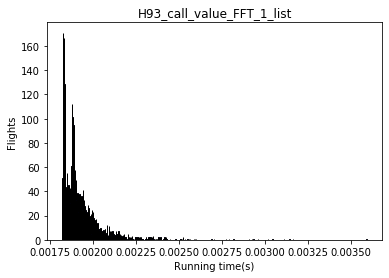

In [16]:
histo(H93_call_value_FFT_1_list, "H93_call_value_FFT_1_list")
getMean(H93_call_value_FFT_1_list, "H93_call_value_FFT_1_list")

The mean H93_call_value_1_list 0.00645


0.00644896273612976

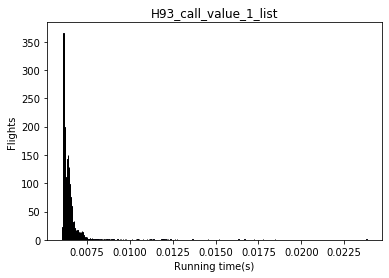

In [17]:
histo(H93_call_value_1_list, "H93_call_value_1_list")
getMean(H93_call_value_1_list, "H93_call_value_1_list")

The mean BSM_call_valueAnalytical_1_list 0.0003


0.00029603958129882814

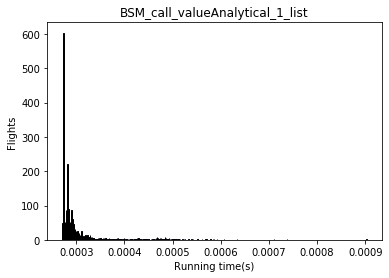

In [18]:
histo(BSM_call_valueAnalytical_1_list, "BSM_call_valueAnalytical_1_list")
getMean(BSM_call_valueAnalytical_1_list, "BSM_call_valueAnalytical_1_list")